# NLP Senitment Analysis - IMDB Movie Reviews

The following is a notebook which uses the google ML guide for text classification. In this notebook the aim is to perform sentiment analysis on the IMDB Movie Reviews dataset to determine whether a particular review is positive or negative.

Google ML Text Classification Guide: https://developers.google.com/machine-learning/guides/text-classification/

The dataset used in this notebook is downloaded from the following location: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import operator
%matplotlib inline

# Pre-processing - Loading the dataset

Load the dataset in and perform a train/test split. The "data_path" parameter should just be set to wherever the dataset has been downloaded to locally on your machine.

In [2]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = data_path

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname), encoding="utf8") as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding="utf8") as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [3]:
(train_X, train_y), (test_X, test_y) = load_imdb_sentiment_analysis_dataset(data_path='imdb_google')

# Collecting Key Metrics

Once we have loaded the dataset into memory, there are a number of key metrics that can help us understand our dataset and the type of classification problem that we have.

In [4]:
print ("Number of training set samples: {}".format(len(train_X)))
print ("Number of test set samples: {}".format(len(train_X)))
print("Number of samples per class: {}".format(len(set(train_y))))

Number of training set samples: 25000
Number of test set samples: 25000
Number of samples per class: 2


In [5]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [6]:
print("Number of words per sample train (median): {}".format(get_num_words_per_sample(train_X)))
print("Number of words per sample test (median): {}".format(get_num_words_per_sample(test_X)))

Number of words per sample train (median): 174.0
Number of words per sample test (median): 172.0


In [7]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

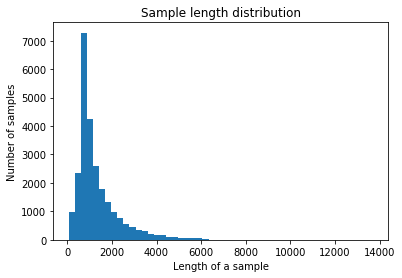

In [8]:
plot_sample_length_distribution(train_X)

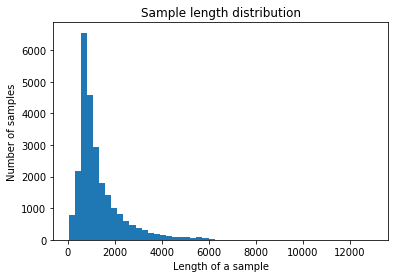

In [9]:
plot_sample_length_distribution(test_X)

# Frequency Distribution of Words for IMDB

Count all the words in the training set and then show them in a frequency distribution plot

In [10]:
nlp = spacy.load('en_core_web_sm')

In [11]:
samples = train_X
review_dict = {}
for sample in samples:
    text = nlp(sample)
    for token in text:
        if token.lemma_ in review_dict:
            review_dict[token.lemma_] +=1
        else:
            review_dict[token.lemma_] = 1

In [12]:
print("Number of distinct words in the training set: {}".format(len(review_dict)))

Number of distinct words in the training set: 91038


# Plotting the Frequency Distribution

This is the unigrams along the x-axis with the number of times that each unigram appears along the y-axis

In [13]:
sorted_d = sorted(review_dict.items(), key=operator.itemgetter(1),reverse=True)

In [14]:
d = {key: value for (key, value) in sorted_d[10:30]}

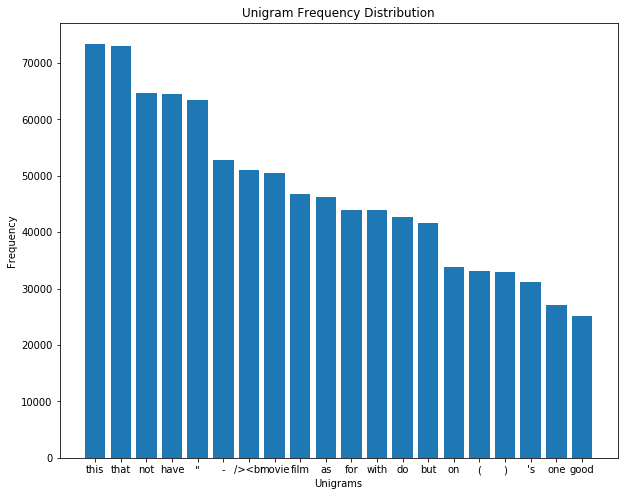

In [16]:
plt.figure(figsize=(10,8))
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()))
plt.xlabel('Unigrams')
plt.ylabel('Frequency')
plt.title('Unigram Frequency Distribution')
plt.show()

Looking at the unigram frequency distribution plot, there are some unigrams which appear to be non-alphabetic words. e.g ", -, /> etc

One improvement to make would be to remove these from each review in the training set as they do not tell us information about the sentiment of the review. 

# Train/Test Split Statification

In the earlier stages of the notebook, we performed a train/test split on the data (used the manual method as walked through by the google tutorial rather than sci-kit learn train/test split package). We are now going to check how well distributed the train/test split is with regards to the number of classes that belong to each.

Remembering from above that 0 is a negative review and 1 is a positive review.

In [23]:
def label_counts(labels):
    negative_counts = 0
    positive_counts = 0
    for label in labels:
        if label == 1:
            positive_counts += 1
        else:
            negative_counts += 1
    return positive_counts, negative_counts

In [24]:
positive_train_counts, negative_train_counts = label_counts(train_y)
positive_test_counts, negative_test_counts = label_counts(test_y)

In [25]:
print("Number of positive labels in train set: {}".format(positive_train_counts))
print("Number of negative labels in train set: {}".format(negative_train_counts))
print("Number of positive labels in test set: {}".format(positive_test_counts))
print("Number of negative labels in test set: {}".format(negative_test_counts))

Number of positive labels in train set: 12500
Number of negative labels in train set: 12500
Number of positive labels in test set: 12500
Number of negative labels in test set: 12500


# Preparing Data

The following code puts together all of the above steps:

Tokenize text samples into word uni+bigrams,
Vectorize using tf-idf encoding,
Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [27]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [28]:
x_train, x_val = ngram_vectorize(train_X, train_y, test_X)

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# Sample Code for Sci-Kit Learn: tf-idf

This sample code is just investigating in detail what the above method ("ngram_vectorize") is doing.

In [29]:
# Config for TfidVectorizer

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [30]:
# Create keyword arguments to pass to the 'tf-idf' vectorizer.
kwargs = {
    'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': TOKEN_MODE,  # Split text into word tokens.
    'min_df': MIN_DOCUMENT_FREQUENCY,
}

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Tfidf vectorizer must remove the unnecessary "<"
corpus = ['This is < the first < document.',
          'This document < is the second document.',
          'And this is the third < one, documents',
          'Is this the first < document documents?',
         ]
vectorizer = TfidfVectorizer(**kwargs)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


['document', 'documents', 'first', 'first document', 'is', 'is the', 'the', 'the first', 'this', 'this is']
(4, 10)


In [46]:
test = vectorizer.inverse_transform(X)
test

[array(['this', 'is', 'the', 'first', 'document', 'this is', 'is the',
        'the first', 'first document'], dtype='<U14'),
 array(['this', 'is', 'the', 'document', 'is the'], dtype='<U14'),
 array(['this', 'is', 'the', 'this is', 'is the', 'documents'],
       dtype='<U14'),
 array(['this', 'is', 'the', 'first', 'document', 'the first',
        'first document', 'documents'], dtype='<U14')]

In [47]:
stop_words = vectorizer.stop_words_
print(stop_words)

{'the second', 'third one', 'third', 'this document', 'and this', 'document documents', 'is this', 'document is', 'second', 'the third', 'one documents', 'one', 'this the', 'and', 'second document'}


In [48]:
print(X)

  (0, 8)	0.25715068083178566
  (0, 4)	0.25715068083178566
  (0, 6)	0.25715068083178566
  (0, 2)	0.38850983776953174
  (0, 0)	0.3145321969754572
  (0, 9)	0.38850983776953174
  (0, 5)	0.3145321969754572
  (0, 7)	0.38850983776953174
  (0, 3)	0.38850983776953174
  (1, 8)	0.3088951258779955
  (1, 4)	0.3088951258779955
  (1, 6)	0.3088951258779955
  (1, 0)	0.7556461625001225
  (1, 5)	0.37782308125006125
  (2, 8)	0.3322044958286398
  (2, 4)	0.3322044958286398
  (2, 6)	0.3322044958286398
  (2, 9)	0.5019030646281711
  (2, 5)	0.40633378679038906
  (2, 1)	0.5019030646281711
  (3, 8)	0.27089970641960254
  (3, 4)	0.27089970641960254
  (3, 6)	0.27089970641960254
  (3, 2)	0.4092822179294197
  (3, 0)	0.3313492289600494
  (3, 7)	0.4092822179294197
  (3, 3)	0.4092822179294197
  (3, 1)	0.4092822179294197


In [49]:
type(X)

scipy.sparse.csr.csr_matrix

In [50]:
X.toarray()

array([[0.3145322 , 0.        , 0.38850984, 0.38850984, 0.25715068,
        0.3145322 , 0.25715068, 0.38850984, 0.25715068, 0.38850984],
       [0.75564616, 0.        , 0.        , 0.        , 0.30889513,
        0.37782308, 0.30889513, 0.        , 0.30889513, 0.        ],
       [0.        , 0.50190306, 0.        , 0.        , 0.3322045 ,
        0.40633379, 0.3322045 , 0.        , 0.3322045 , 0.50190306],
       [0.33134923, 0.40928222, 0.40928222, 0.40928222, 0.27089971,
        0.        , 0.27089971, 0.40928222, 0.27089971, 0.        ]])

# Multi Layer Perceptron - Last Layer Construction

As suggested by the google guide we are going to use a MLP model. Description below is from the guide which highlights the reasoning behind this choice in the tutorial.

*From our experiments, we have observed that the ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.*

*When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call Option A) perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model (Option B)"*

*In the case of our IMDb review dataset, the samples/words-per-sample ratio is ~144*

In [52]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [53]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

C:\Users\Ross\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [54]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

# Training 

In [55]:
import tensorflow as tf

In [56]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=3,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = len(set(train_labels))
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], model

In [57]:
data = ((train_X, train_y), (test_X, test_y))
_, _, model = train_ngram_model(data)

C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\Ross\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
 - 16s - loss: 0.3574 - acc: 0.8723 - val_loss: 0.2381 - val_acc: 0.9026
Epoch 2/1000
 - 16s - loss: 0.1428 - acc: 0.9465 - val_loss: 0.2484 - val_acc: 0.9004
Epoch 3/1000
 - 16s - loss: 0.0926 - acc: 0.9668 - val_loss: 0.2872 - val_acc: 0.8942
Validation accuracy: 0.8942000000190735, loss: 0.2872276952648163


# Results - Classification Report

In [58]:
from sklearn.metrics import classification_report

In [59]:
y_test_pred = model.predict_classes(x_val, batch_size=128)

In [61]:
print(classification_report(test_y, y_test_pred))

             precision    recall  f1-score   support

          0       0.90      0.89      0.89     12500
          1       0.89      0.90      0.89     12500

avg / total       0.89      0.89      0.89     25000

